# Text Analytics - Assignment 2

## Wenying Hu, Jireh Zhou, Sam Malcolm, Stella Sun, Xueru Rong

In [1]:
from selenium import webdriver
import pandas as pd
import numpy as np
import re
import string
import warnings
import nltk
from nltk import word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.metrics import euclidean_distances
warnings.filterwarnings('ignore')


## Preparation - Web Scraper using Selenium & Message processing

chrome_path = r'/Users/ayuan/Desktop/chromedriver'
driver = webdriver.Chrome(chrome_path)

driver.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans")

date=[]  
username=[]  
message=[]  

i=1  
while i in range(1,170):  
    d=driver.find_elements_by_class_name('Permalink')  
    u=driver.find_elements_by_class_name('Username')  
    m=driver.find_elements_by_class_name('Item-Body')  
    for x in d:  
        date.append(x.text)  
    for y in u:  
        username.append(y.text)  
    for z in m:  
        message.append(z.text)  
    driver.find_element_by_css_selector('a.Next.Pager-nav').click()  
    driver.find_element_by_css_selector('a.Next.Pager-nav').click()   
    driver.find_element_by_css_selector('a.Next.Pager-nav').click()  
    driver.find_element_by_css_selector('a.Next.Pager-nav').click()  
    i+=1  

len(date)  

df=pd.DataFrame({'date':date,'username':username,'message':message})

df.to_csv('Edmund.csv', encoding='utf-8',header=True, index=False)

df1=pd.read_csv('Edmund.csv')

**Remove the depulicates from the models table**    
models=pd.read_csv('models.csv',header=None)  
models.columns=['brand','model']  
for i in range(len(models)):  
    models.iloc[i]['model']=models.iloc[i]['model'].lower()  
    for p in punctuation:  
        models.iloc[i]['brand']=models.iloc[i]['brand'].replace(p,'').lower()  
models=models.drop_duplicates(subset='model')  

**Remove punctuations and spaces, substitute the models with the brands**  
for i in range(len(df1)):  
    df1.iloc[i]['message']= ''.join([c for c in str(df1.iloc[i]['message']) if c not in string.punctuation]).lower()  
    df1.iloc[i]['message']= str(df1.iloc[i]['message']).replace('\n', " ")  
    df1.iloc[i]['message']= str(df1.iloc[i]['message']).replace('\r', " ")  
    for m in range(len(models)):  
        df1.iloc[i]['message']= str(df1.iloc[i]['message']).replace(models.iloc[m]['model'], models.iloc[m]['brand'])  

df1.to_csv('Edmund_processed.csv')

### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task). Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on the Internet). 

#### Top10 brands

In [2]:
df2=pd.read_csv('Edmund_processed.csv')
mes_str=' '
for m in df2['message']:
    mes=' '.join(str(s) for s in set(word_tokenize(str(m))))
    mes_str=mes_str+mes

In [3]:
#text=pd.read_csv("Output.txt")
#mes_str = str(text)
mes_list=mes_str.split()
word_count=pd.Series(mes_list).value_counts().reset_index()
word_count.columns=['word','count']

In [4]:
brands=pd.read_csv('carbrands.csv',header=None)
brands.columns = ['brand']
b_count=word_count[word_count['word'].isin(brands['brand'])]

In [5]:
b_count.columns=['brand','count']
b_count.sort_values(by='count',ascending=False)[:10]

,brand,count
23,bmw,1490
57,acura,825
78,audi,661
91,infiniti,588
104,honda,547
106,lexus,534
162,volkswagen,324
177,ford,310
198,hyundai,289
239,nissan,248


The top 10 brands with highest frequencies are: BMW, Acura, Audi, Infiniti, Honda, Lexus, Volkswagen, Ford, Hyundai, and Nissan.

#### Lift ratio

In [6]:
import pandas as pd
import string
from string import punctuation
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
brands=pd.read_csv('carbrands.csv',header=None)
brands.columns=['brand']
brand_list=list(brands['brand'])

In [8]:
df=pd.read_csv('Edmund_processed.csv')
df=df[['date','message','username']]

In [9]:
mes_list=list(df['message'].dropna())
matrix = CountVectorizer(stop_words='english',binary=True)
freq= pd.DataFrame(matrix.fit_transform(mes_list).toarray())
freq.columns=matrix.get_feature_names()

In [10]:
cols=[col for col in freq.columns if col in brand_list]
freq2=freq[cols]

In [61]:
sets=apriori(freq2, min_support=.00, use_colnames=True, max_len=2)
rules=association_rules(sets, metric="lift")
rules=rules[['antecedents','consequents','lift']]
rules

,antecedents,consequents,lift
0,(lexus),(porsche),1.260629
1,(porsche),(lexus),1.260629
2,(saturn),(infiniti),2.460155
3,(infiniti),(saturn),2.460155
4,(kia),(pontiac),0.800981
5,(pontiac),(kia),0.800981
6,(lincoln),(infiniti),1.540834
7,(infiniti),(lincoln),1.540834
8,(honda),(toyota),3.508806
9,(toyota),(honda),3.508806


#### MDS

In [62]:
# Convert frozensets to string
rules['antecedents'] = rules['antecedents'].map(lambda s: list(s)).map(lambda s: str(s)).map(lambda s: s[3:-2])
rules['consequents'] = rules['consequents'].map(lambda s: list(s)).map(lambda s: str(s)).map(lambda s: s[3:-2])

# Take inversion of lift for MDS plot
rules['lift_inv'] = 1/rules['lift']

In [63]:
lift_matrix = pd.pivot_table(rules, columns = 'antecedents', index = 'consequents',values = 'lift_inv', fill_value="0").sort_index(axis=0).sort_index(axis=1)
lift_matrix

antecedents,acura,audi,bmw,buick,cadillac,chevrolet,chrysler,dodge,ford,honda,...,mitsubishi,nissan,pontiac,porsche,saturn,subaru,suzuki,toyota,volkswagen,volvo
consequents,,,,,,,,,,,,,,,,,,,,,
acura,0,0.568216,0.867869,0.476524,0.417611,0.823622,0.974023,0,1.13477,0.448507,...,0.215972,0.440421,1.00894,0.784088,0,0.836293,0.395339,0.644448,0.62059,0.436651
audi,0.568216,0,0.64404,0.496678,0.311308,0.710001,0.189139,0.899335,0.972537,0.713415,...,0.994889,0.901702,0.826264,0.573326,0.944302,0.684878,0.323761,0.716256,0.263299,0.288825
bmw,0.867869,0.64404,0,0.766042,0.584634,1.00484,1.15081,0.714552,0.958462,0.862691,...,0,1.03384,0.875326,0.659729,0,0.922704,0,0.805678,1.04182,0.654861
buick,0.476524,0.496678,0.766042,0,0.159984,0.19998,0.241754,0.159984,0.619939,0.463112,...,0.943907,0.81272,0.156785,0.634604,0.0373296,0.70393,0,0.209862,0,0.242885
cadillac,0.417611,0.311308,0.584634,0.159984,0,0.395023,0.537231,0.35552,0.918428,0.514569,...,1.04879,1.12878,0.248864,0.470077,0.248864,0.782145,0.213312,0.377529,0.639937,0.237488
chevrolet,0.823622,0.710001,1.00484,0.19998,0.395023,0,0.383736,0.395023,0.340158,0.47231,...,1.16532,0.627099,0.138258,0.167885,0.069129,0.86905,0,0.629215,0.492259,0
chrysler,0.974023,0.189139,1.15081,0.241754,0.537231,0.383736,0,0.214892,0.520442,0.671539,...,0.528277,0.852854,0.438739,0.639305,0,1.18191,0.161169,0.399342,0.0956389,0.897176
dodge,0,0.899335,0.714552,0.159984,0.35552,0.395023,0.214892,0,0.40819,0.543156,...,0,0.668905,0.193561,0.470077,0,1.04286,0,0.44045,0.511949,0.659688
ford,1.13477,0.972537,0.958462,0.619939,0.918428,0.340158,0.520442,0.40819,0,0.748349,...,0,0.864002,0.375025,1.21437,0,0.621705,0,0.620635,0.826585,0.60148


In [64]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=1,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(lift_matrix).embedding_

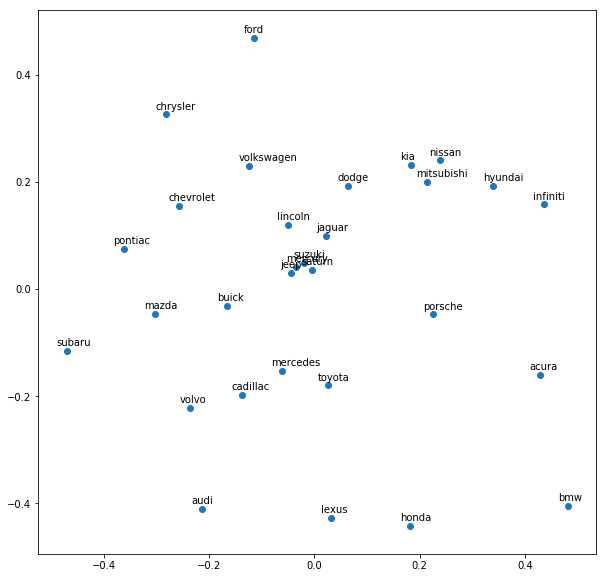

In [65]:
mds_brands = list(lift_matrix.index.values)

pos_x = [x[0] for x in pos]
pos_y = [x[1] for x in pos]
plt.figure(figsize=(10,10))
plt.scatter(pos_x, pos_y)
for i in range(len(mds_brands)):
    plt.text(pos_x[i]-0.02, pos_y[i]+0.01, mds_brands[i])
plt.show()

### Task B: What insights can you offer brand managers from your analysis in Task A (choose two brands that you can offer the most interesting/useful insights for)? 

To the Lexus brand manager: While your competitors Audi, BMW, and Acura are each well positioned in isolation, Lexus is relatively closely associated with Honda. We believe it would be beneficial for you to work toward a more singular position in the brand space. Consumers may currently see a potential trade-off between Lexus (a luxury brand) and Honda (a more economic brand). This may not be ideal. However, you should feel encouraged that you have one clear association rather than several (like Mercedes). Having just one competitor to position yourself against is much more manageable. It is worth investigating this association further to learn how you may be able to differentiate your brand from Honda.

To the BMW brand manager: As you can see, BMW has very successfully differentiated itself from the rest of the brands in the market and as such your footing should be relatively secure. I would feel comfortable with the position you've attained. With this cushion, now is the time to move forward with ambitious initiatives and potential paradigm-shifting projects that in more uncertain circumstances might be too risky to attempt. 

### Task C: What are 5 most frequently mentioned attributes of cars in the discussions? Note that the same attribute may be described by different words – e.g., pick-up and acceleration may both refer to a more general attribute, “performance”. You have to make suitable replacements. Now pick the 5 most frequently mentioned brands. Which attributes are most strongly associated with which of these 5 brands? You DON’T have to do a sentiment analysis for this assignment.

#### 5 most frequently mentioned attributes

In [16]:
attributes=pd.read_csv('attributes.csv')

In [17]:
replaced_mes=[]
for item in mes_list:
    for attribute in attributes.columns:
        for words in list(attributes[attribute].dropna()):
            if words in item:
                item=re.sub(words,attribute,item)
    replaced_mes.append(item)

In [18]:
mes_str_replaced=''
for item in replaced_mes:
    mes_str_replaced+=' '+item

In [19]:
mes_list_replaced=mes_str_replaced.split()

In [20]:
word_count_replaced=pd.Series(mes_list_replaced).value_counts().reset_index()
word_count_replaced.columns=['word','count']

In [21]:
b_count_replaced=word_count_replaced[word_count_replaced['word'].isin(attributes.columns)]

In [22]:
b_count_replaced[:5]

,word,count
47,performance,1482
49,price,1458
70,interior,1034
100,size,753
158,exterior,446


#### Attributes strongly associated with Top 5 brands

In [23]:
top5_attribute=list(b_count_replaced[:5]['word'])
top5_brand=list(b_count.sort_values(by='count',ascending=False)[:5]['brand'])

In [24]:
matrix = CountVectorizer(stop_words='english',binary=True)
freq_replaced = pd.DataFrame(matrix.fit_transform(replaced_mes).toarray())
freq_replaced.columns=matrix.get_feature_names()

In [25]:
#lift matrix
brand_attribute_lift = pd.DataFrame(np.zeros((5, 5)), columns = top5_attribute, index = top5_brand)

In [26]:
freq1 = pd.DataFrame(matrix.fit_transform(mes_list).toarray())

In [27]:
#calculating lift between brands and features
for i, brand in enumerate(brand_attribute_lift.index):
    try:
        sumA = freq_replaced[brand].sum()
    except:
        sumA = 0
    for j, attribute in enumerate(brand_attribute_lift.columns.values):
        try:
            sumB = freq_replaced[attribute].sum()
        except:
            sumB = 0
        try:
            sumAB = ((freq_replaced[brand] + freq_replaced[attribute]) == 2).sum()
        except:
            sumAB = 0
        lift = 5071 * sumAB / float(sumA * sumB)
        brand_attribute_lift.iloc[i, j] = lift

In [28]:
brand_attribute_lift

,performance,price,interior,size,exterior
bmw,1.528170,1.544345,1.190525,1.309469,1.261971
acura,1.199565,1.379572,1.402384,1.501049,1.329462
audi,1.449269,1.817155,1.871439,1.939161,1.599511
infiniti,1.323330,1.630617,1.264496,1.218798,1.636093
honda,1.289645,1.433361,1.124020,1.500930,1.423023


### While BMW has claimed that they are the “ultimate driving machine”, is that how people feel on Edmunds? Show your analysis.   


From what we have above, we can see that people talk about BMW's performance more than any other top 5 cars. Among all the attributes in the top 5 brands, price is likely to be discussed, but performance is also the second highest attribute that are likely to discussed by people. Besides, lift ratios of BMW's performance and price seems not have a big distinction. Thus, we know that it is reasonable for BMW to claim that they are the "ultimate driving machine".


### Task D: What advice will you give to a (i) product manager, and (ii) marketing/advertising manager of these brands based on your analysis in Task C? For this assignment, you can assume the sentiment (e.g., that it is positive). 


Among the 5 attributes for the top 5 brands except Audi, interior and size are always the least or the second least attributes discussed by people. There might be drawbacks or few strengths with interior and size and therefore people are less likely to talk about interior and size of these 4 brands. Thus, product managers of these 4 brands need to improve the situation and build better products. Audi has high lift ratio with interior and size and therefore the marketing manager at Audi can focus on advertise the ultimate interior and size of Audi cars. 

Each brand has its advantage on one attribute with high lift ratio. Therefore, marketing managers can advertise more on the attribute to customers. For the attributes with lower lift ratio, product managers need to pay more attention on these attributes and make improvements to obtain customer preference.

### Task E: Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [29]:
Asp = ['want', 'wanted', 'hope', 'wish', 'desire', 'buy', 'desired', 'dream', 'goal', 'ideal', 
       'love', 'like', 'purchase', 'own']

In [30]:
brand_asp_lift = pd.DataFrame(np.zeros((30, 14)), columns = Asp, index = brand_list)
for i, brand in enumerate(brand_asp_lift.index):
    try:
        sumA = freq[brand].sum()
    except:
        sumA = 1
    for j, asp in enumerate(brand_asp_lift.columns.values):
        try:
            sumB = freq[asp].sum()
        except:
            sumB = 1
        try:
            sumAB = ((freq[brand] + freq[asp]) == 2).sum()
        except:
            sumAB = 0
        lift = 5071 * sumAB / float(sumA * sumB)
        brand_asp_lift.iloc[i, j] = lift
brand_asp_lift.sum(axis = 1).sort_values(ascending = False)

buick         37.889172
mercury       35.632715
dodge         35.044731
mercedes      31.348394
cadillac      25.194308
mazda         23.734461
lexus         23.435662
lincoln       22.756370
chevrolet     22.470779
porsche       22.234818
volkswagen    20.156085
audi          20.154528
bmw           20.093530
chrysler      18.151535
acura         18.098197
ford          17.746103
volvo         17.560988
infiniti      17.456019
mitsubishi    17.428189
toyota        17.387199
subaru        17.129589
honda         16.910890
nissan        16.638395
saturn        16.563253
jaguar        16.525070
kia           16.512529
pontiac       12.352363
hyundai        9.488955
jeep           6.984810
suzuki         5.325198
dtype: float64

First, we created a group of words indicating that a user would want to buy or own a car, such as 'desire', 'dream', 'hope', etc. We then calculated the lift between those words and each car brand. Finally, we summed the lift scores of words for each brand. 

In this case, it turns out BUICK is the most aspirational brand, beacuse BUICK has the highest sum of lifts. However, MERCURY, DODGE and MERCEDES are very close to BUICK, because their sums of lifts are all above 30. 

This is somewhat surprising considering that only MERCEDES could potentially be considered a "luxury" brand amongst this group. However, this should be considered a very positive sign for these brands.  It is a clear indication that these brands represent quality and value relative to their competition to the knowledgable car buyers that navigate the Edmunds forum.